# PyGrid: Remote Inference (Data Scientist)

<img src="../../../docs/img/pygrid_logo.png" align="center"/>

Evaluate custom models using private datasets without having access to them is a powerfull resource that can change the way we interact with data during a machine learning workflow, PySyft and PyGrid offers the ability to run inferences remotely by using a variety of technologies and applications.

In this notebook series, we'll be covering all the nuances of this process, showing how to send private datasets _(as data owner)_, and how to perform remote computation using private environments _(as data scientist)_.<br><br>The main goal of these notebooks is to explore different techniques and technologies that can turn **private data _"accessible"_ while also empower data owners with total control of their own data.**


**NOTE**: _This notebook was designed to be executed in pair with the [\[Data Owner\] PyGrid Remote Inference](http://github.com/OpenMined). In order to reproduce it properly, follow the checkpoints and instructions described in the next sections._

### Overview

- [**Creating User accounts**](#creating-user-accounts)
- [**Remote Datasets**](#create-a-compliance-officer-account)
- [**Train a local model**]()
- [**PyGrid workers**](#setting-computing-environment)
- [**Remote inference**](#remote-inference)
- [**## Data retrieval + Differencial Privacy**](#data-access-request)

## Creating User accounts

#### Import libs

In [1]:
from syft.grid.client.client import connect # Method used to connect with the domain.
from syft.grid.client.grid_connection import GridHTTPConnection # Protocol used to talk with the domain

import syft as sy
import torch as th

# Set logging level
import logging
logging.basicConfig(level=logging.INFO)

import pydp
sy.load('pydp')

#### Create User account
In this scenario, we're assuming that the data scientist will start from scratch.

In [2]:
# Since we still don't have our own account,
# we can connect with the domain without credentials.
unauthenticated_client = connect(
    url="http://localhost:5000", # Domain Address
    conn_type=GridHTTPConnection,) # HTTP Connection Protocol

unauthenticated_client.users.create(email="scientist@researchorg.edu", password="pwd123")

# Now we can finally log-in using our credentials.
domain_client = connect(
    url="http://localhost:5000", # Domain Address
    credentials={"email":"scientist@researchorg.edu", "password":"pwd123"},
    conn_type=GridHTTPConnection,) # HTTP Connection Protocol

INFO:root:User created successfully!


Done! We have an User account!

## Remote Datasets

### Checking for available datasets
Now, let's take a look at the domain repository.

In [3]:
domain_client.datasets.all(pandas=True)

,id,manifest,description,tags,data
0,94943721-e2ae-4972-b1c2-7854b0576d28,This dataset is originally from the National I...,This dataset is originally from the National I...,"[#diabetes, #pima-indians-database]","[{'name': 'diabetes-data/data_02.csv', 'id': '..."


In [4]:
remote_dataset = domain_client.datasets["94943721-e2ae-4972-b1c2-7854b0576d28"]

As we can see, we have a dataset available to be used. Datasets are robust grid structures that were designed to point to several remote data, obeying the structure of those who created it,  they can represent csv files, images, or even the abstraction of train/test datasets. In this example, we'll be covering a dataset composed by different CSV files _(although, they are no longer being stored in their original structure (CSV file) inside of the domain)_.

### Exploring the metadata
As you probably know, we can't have access to the real values of the dataset. It's private and remote! However, we can explore its metadata information in order to understand how the data has been organized.

#### Manifest
Dataset manifest is a document commonly used to describe the data meaning. Here, we expect to know the meaning of each column, their object types and the purpose of the dataset.

In [5]:
print(remote_dataset.manifest)

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Diabetes files consist of 8 fields per record.  Each field is
separated by a comma and each record is separated by a newline.

CSV Columns and format:
(1) Pregnancies (Integer) : Number of times pregnant
(2) Glucose (Integer) : Plasma glucose concentration a 2 hours in an oral glucose tolerance test
(3) Blood Pressure (Integer) : Diastolic blood pressure (mm Hg)
(4) Skin Thickness (Integer) : Triceps skin fold thickness (mm)
(5) Insulin (Integer) : 2-Hour serum insulin (mu U/ml)
(6) BMI (Float) : Body mass index (weight in kg/(height in m)^2)
(6) Diabetes Pedigree (Float) : Diabetes Pedigree Function
(7) Age (In

#### Tags
Commonly used to give an overview about the data.

In [6]:
remote_dataset.tags

['#diabetes', '#pima-indians-database']

#### Dataset Pandas
Used to understand how the dataset pointers are organized, what's their types, shape and name.

In [7]:
remote_dataset.pandas

,name,id,dtype,shape
0,diabetes-data/data_02.csv,3cb1b048-02d7-40b2-9e39-7834fd98fa96,Tensor,"(200, 9)"
1,diabetes-data/data_06.csv,0701de80-8913-469e-b9af-45ad0046d292,Tensor,"(200, 9)"
2,diabetes-data/data_10.csv,ce9955d0-89d5-40bc-99e1-2f6dbc13e3da,Tensor,"(200, 9)"
3,diabetes-data/data_03.csv,3973793e-3ff6-431a-9789-793e259c0ddd,Tensor,"(200, 9)"
4,diabetes-data/data_04.csv,b0bbc51e-fc61-4c93-9335-dd4f39a2baa2,Tensor,"(200, 9)"
5,diabetes-data/new_data.csv,c4bd6609-5ed9-4432-bc1b-390f11270a9e,Tensor,"(2000, 9)"
6,diabetes-data/data_07.csv,3508dfc3-941c-42e7-a2f1-0ddee84b3bb2,Tensor,"(200, 9)"
7,diabetes-data/data_08.csv,b35cb625-00ef-494b-a318-21115ce2c695,Tensor,"(200, 9)"
8,diabetes-data/data_09.csv,213c1e8e-2520-4d82-92e5-d9a4ff202021,Tensor,"(200, 9)"
9,diabetes-data/data_05.csv,37fc6be6-157e-4c7e-987c-03df0447d35a,Tensor,"(200, 9)"



_PS: At the time this notebook has been written, the domain was only supporting compressed "tar.gz" files  as a dataset. Contact the author of this article to find out the current status of this feature._

## Train a local model

epoch 0	loss : 0.707695722579956	 accuracy : 0.3765
epoch 50	loss : 0.5054161548614502	 accuracy : 0.7865
epoch 100	loss : 0.48468953371047974	 accuracy : 0.7945
epoch 150	loss : 0.4681723713874817	 accuracy : 0.8
epoch 200	loss : 0.4556426405906677	 accuracy : 0.809
epoch 250	loss : 0.44409283995628357	 accuracy : 0.82


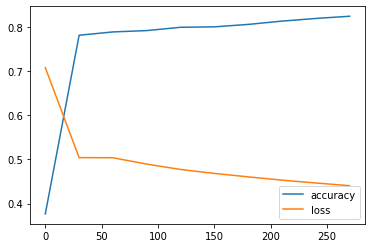

In [8]:
from diabetes_model_training import train_diabetes_model, plot_training_acc
model, loss, acc, epochs_list = train_diabetes_model(th)
plot_training_acc(acc, loss, epochs_list)

## PyGrid workers

PyGrid aims to provide a custom and private environment for the users to perform their computation. That way, the user is empowered to choose their computing resources. We're currently supporting Azure, GCP and Amazon. In this notebook we'll be using Azure as a cloud platform since it provides an additional secure layer based in a Trusted Execution Environment (TEE). That way, the data owner can protect his data from the user and also from the infrastructure where the domain lives.

#### Get Instance type
First, we need to know what instances are available to be deployed.

In [ ]:
domain_client.workers.instance_type(pandas=True)

#### Create a worker
Once we decided about the vm instance, we can request for the domain to create one for us.

In [10]:
domain_client.workers.create(instance_type="t2.large")
domain_client.workers.all(pandas=True)

INFO:root:Worker created successfully!


,id,state,provider,region,instance_type,address,created_at,destroyed_at
0,1,2,Azure,sa-sao_paulo,local_instance,localhost:5001,2021-04-25 10:45:41.672469,2021-04-25 10:43:50.451461


Then, with the worker deployed, we can get a proxy client which will be used to send messages to the environment through the domain.

In [11]:
worker = domain_client.workers[1]
print("Worker Provider: ", worker.provider)
print("Worker Instance Type: ", worker.instance_type)
print("Worker Region:", worker.region)
print("Worker Syft (Logic) Address", worker.address)

Worker Provider:  Azure
Worker Instance Type:  local_instance
Worker Region: sa-sao_paulo
Worker Syft (Logic) Address <Address - Domain:<SpecificLocation:..85753>>


#### Loading private dataset
Ok, now we have the worker able to perform remote computation, but it's still empty. In order to transfer private datasets and tensors we must use the _load_ method. This method will get a pointer of an object that lives in the domain, and send it to our worker.

In [12]:
# 1 - Let's choose one of those dataset pointers to be our data sample during the remote inference
private_data_sample = remote_dataset.files[0]
print( "Dataset Name: ", private_data_sample.name )
print( "Dataset Shape: ", private_data_sample.shape )
print( "Dataset Type: ", private_data_sample.dtype )
print( "Dataset Pointer: ", private_data_sample.pointer )

# 2 - Then we can load it from the domain to our own worker.
domain_client.load(private_data_sample.pointer, worker.address)

# 3 - Finally, we can see the data inside the worker store
worker.store.pandas

Dataset Name:  diabetes-data/data_02.csv
Dataset Shape:  (200, 9)
Dataset Type:  Tensor
Dataset Pointer:  <syft.proxy.torch.TensorPointer object at 0x7fb3eb4ab7f0>


,ID,Tags,Description,object_type
0,<UID: 06879560e5794e3bb823f38ae5b47ae1>,"[#diabetes, #pima-indians-database, #data_02.csv]",,<class 'torch.Tensor'>


#### Loading a model
Let's do the same thing with our model trained locally.

In [13]:
# PS: Since we're transfering the model from our own machine to our Virtual Machine
# we'll be using "send" instead of load
remote_model = model.send(worker)

## Remote Inference + Differential Privacy
**Finally!** We have everything ready! 

#### Running inference

In [14]:
# Spliting the private data set into features and labels
feature = worker.store[0][0:,0:8]
labels = worker.store[0][0:,8]

predicted = remote_model(feature)

#### Computing accuracy
Now, we need to compare the predicted results with the private dataset labels.

In [15]:
acc =  (predicted.reshape(-1).round() == labels).int().tolist()

#### Adding noise
To increase the data security we'll be adding a small noise on our result by using Differential Privacy techniques. <br><br>
Since we intend to compute the accuracy of our prediction, we can just perform a private mean which can vary from 0 to 1. For this example we're defining our privacy budget equals to 0.8.

In [16]:
BoundedMean = worker.pydp.algorithms.laplacian.BoundedMean
mean_ptr = BoundedMean(0.8, lower_bound=0.01, upper_bound=1.0, dtype="float")

In [17]:
acc_result = mean_ptr.quick_result(acc)

#### Saving the results
Before deleting our ephemeral instance we must save the result of our computation. We can do it by using the _save_ command. This command will send a data from our worker to the domain.

In [18]:
# 1 - Sending from worker to domain
worker.save(acc_result)

# 2 - Deleting our Virtual Machine
#del domain_client.workers[1]

## Data retrieval + Differencial Privacy
The last step is to request the compliance officer for data access permissions.

In [19]:
domain_client.store.pandas

,ID,Tags,Description,object_type
0,<UID: 3cb1b04802d740b29e397834fd98fa96>,"[#diabetes, #pima-indians-database, #data_02.csv]",,<class 'torch.Tensor'>
1,<UID: 0701de808913469eb9af45ad0046d292>,"[#diabetes, #pima-indians-database, #data_06.csv]",,<class 'torch.Tensor'>
2,<UID: ce9955d089d540bc99e12f6dbc13e3da>,"[#diabetes, #pima-indians-database, #data_10.csv]",,<class 'torch.Tensor'>
3,<UID: 3973793e3ff6431a9789793e259c0ddd>,"[#diabetes, #pima-indians-database, #data_03.csv]",,<class 'torch.Tensor'>
4,<UID: b0bbc51efc614c939335dd4f39a2baa2>,"[#diabetes, #pima-indians-database, #data_04.csv]",,<class 'torch.Tensor'>
5,<UID: c4bd66095ed94432bc1b390f11270a9e>,"[#diabetes, #pima-indians-database, #new_data....",,<class 'torch.Tensor'>
6,<UID: 3508dfc3941c42e7a2f10ddee84b3bb2>,"[#diabetes, #pima-indians-database, #data_07.csv]",,<class 'torch.Tensor'>
7,<UID: b35cb62500ef494ba31821115ce2c695>,"[#diabetes, #pima-indians-database, #data_08.csv]",,<class 'torch.Tensor'>
8,<UID: 213c1e8e25204d8292e5d9a4ff202021>,"[#diabetes, #pima-indians-database, #data_09.csv]",,<class 'torch.Tensor'>
9,<UID: 37fc6be6157e4c7e987c03df0447d35a>,"[#diabetes, #pima-indians-database, #data_05.csv]",,<class 'torch.Tensor'>


In [20]:
acc_ptr = domain_client.store['0cbd040781a04559ba40e983723d8d2c']

Done! We have an accuracy data stored somewhere inside of our domain. Now let's finally request the data access.

In [21]:
acc_ptr.request(reason="I'd like to have access to my accuracy result!")

### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint : Now STOP and run the Data Owner notebook until the next checkpoint.

In [23]:
acc_ptr.get()

0.7608340382575989

**_Voilà!_** This is our accuracy result!

## Congratulations!!! - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement toward privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways!

### Star PySyft and SyMPC on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool tools we're building.

* [Star PySyft](https://github.com/OpenMined/PySyft)
* [Star PyGrid](https://github.com/OpenMined/PyGrid)

### Join our Slack!
The best way to keep up to date on the latest advancements is to join our community! You can do so by filling out the form at http://slack.openmined.org

### Join a Code Project!
The best way to contribute to our community is to become a code contributor! At any time you can go to PySyft GitHub Issues page and filter for "Projects". This will show you all the top level Tickets giving an overview of what projects you can join! If you don't want to join a project, but you would like to do a bit of coding, you can also look for more "one off" mini-projects by searching for GitHub issues marked "good first issue".

* [PySyft Good First Issue Tickets](https://github.com/OpenMined/PySyft/labels/Good%20first%20issue%20%3Amortar_board%3A)
* [PyGrid Good First Issue Tickets](https://github.com/OpenMined/PyGrid/labels/good%20first%20issue)

### Donate
If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go toward our web hosting and other community expenses such as hackathons and meetups!

* [OpenMined's Open Collective Page](https://opencollective.com/openmined)